In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
import os

drive.mount('/content/drive')

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'kaggle/test1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.ipynb_checkpoints', 'attack.ipynb']


## 搭建网络+验证网络

In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


model = torchvision.models.resnet18(pretrained=True)
for p in model.parameters():  # 模型参数不变
  p.requires_grad=False
model.eval()            # 评估模式

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# !curl -X GET https://github.com/pytorch/hub/raw/master/images/dog.jpg --output img.jpg
# !wget -X GET https://github.com/pytorch/hub/raw/master/images/dog.jpg -o img.jpg
# 好像这个从github上下不下来

In [4]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "img.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [5]:
ls img.jpg

img.jpg


In [6]:
x = Image.open('img.jpg')
preprocess = transforms.Compose([   # 图像预处理
    transforms.Resize(256),     # 按比例缩放图片
    transforms.CenterCrop(224),   # 剪切图片成3*224*224
    transforms.ToTensor(),     # 转换成张量
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 标准化;但标准化后很难攻击
])
x = preprocess(x)
x = x[None, :,:,:]  # or x = x.unsqueeze(0)
display(x.shape)

torch.Size([1, 3, 224, 224])

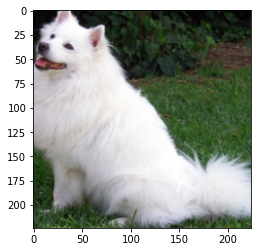

In [7]:
yhat = torch.zeros(1,1000)
yhat[:,133]=1 # 萨摩耶
if torch.cuda.is_available():
  x = x.to('cuda')
  model.to('cuda')
  yhat = yhat.to('cuda')

# with torch.no_grad():
y = model(x)
plt.imshow(torch.permute(x.detach().cpu()[0],[1,2,0]))
ox = x.clone()

torch.Size([1, 1000])

tensor(258, device='cuda:0')

tensor(993, device='cuda:0')

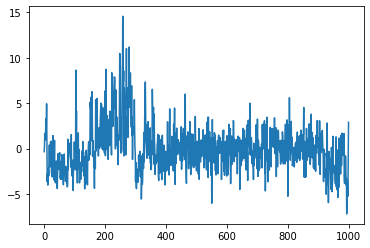

In [8]:
display(y.shape)    # 1000类(imageNet训练的)
display(y[0].argmax())     # 被分为第258类--Samoyed, Samoyede萨摩耶
display(y[0].argmin())     # 133--bittern沼泽鸟 可能性最小
plt.plot(y[0].detach().cpu().numpy())

## 攻击(带目标的FGSM)

In [9]:
obj = int(y[0].argmin()) # 目标类133
lr = 0.007
vals = []
for i in range(200):
  x.requires_grad = True  # 作为变量(生成对抗样本)
  y = model(x)
  # loss = -2*torch.mean(y[: 5])+0.3*torch.mean((x-ox)**2)  # 这个loss效果很差(梯度很小)
  loss = F.cross_entropy(y, yhat) # 交叉熵损失(这里是和133类间的loss)
  loss.backward()
  vals += [loss.item()]
  # grad = torch.clone(x.grad)
  grad = x.grad[:,:,:,:]
  with torch.no_grad():
    x = x-grad*lr   # x对目标类梯度下降   # fgsm:x = x-torch.sign(grad)*lr  迭代5次就够了

### 对抗样本show

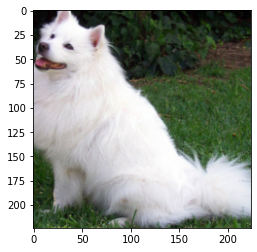

In [10]:
%matplotlib inline
nx = torch.permute(x.detach().cpu()[0],[1,2,0])
nx = np.clip(nx, 0, 1)
plt.imshow(nx)

In [11]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-12-08 04:46:23--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-12-08 04:46:23 (69.9 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



### 识别top5

In [12]:
probabilities = torch.nn.functional.softmax(y[0], dim=0)
# print(probabilities)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(int(top5_catid[i]), categories[top5_catid[i]],top5_prob[i].item())

133 bittern 0.9792648553848267
132 American egret 0.002794121392071247
21 kite 0.0017799524357542396
131 little blue heron 0.0010281694121658802
83 prairie chicken 0.001025663805194199


### loss曲线

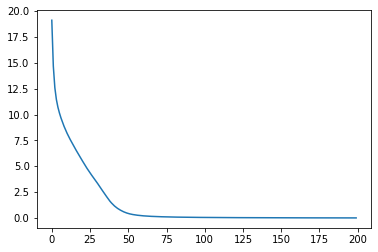

In [13]:
plt.plot(torch.tensor(vals).numpy())

### 识别结果可视化

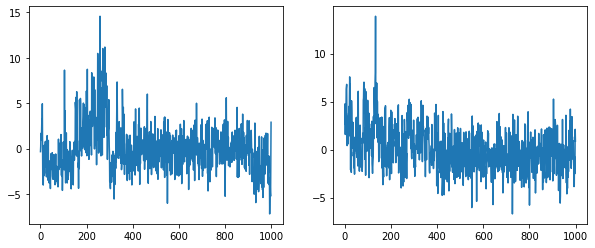

In [14]:
xx = torch.cat((ox, x), 0)
with torch.no_grad():
  yy = model(xx)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(yy[0].detach().cpu().numpy())
plt.subplot(122)
plt.plot(yy[1].detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


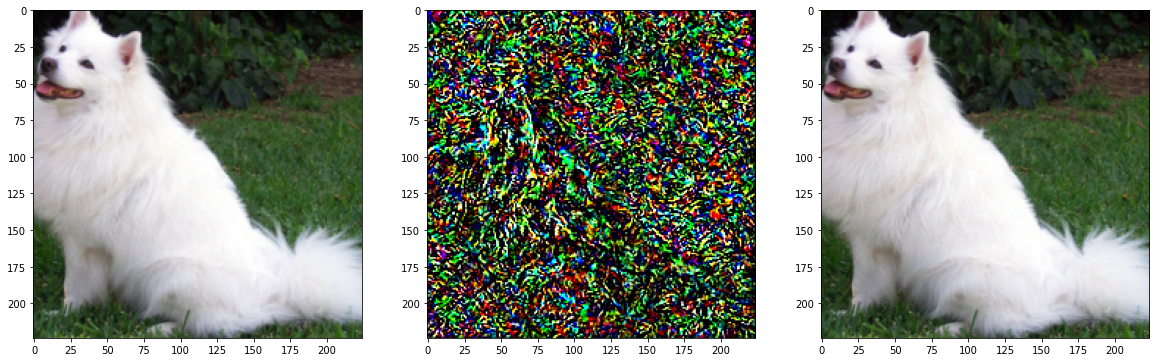

In [15]:
oox = torch.permute(ox.detach().cpu()[0],[1,2,0])
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(oox)
plt.subplot(132)
plt.imshow((oox-nx)/0.007)
plt.subplot(133)
plt.imshow(nx)

In [17]:
display(oox)
display(nx)

tensor([[[0.0431, 0.0471, 0.0431],
         [0.0431, 0.0471, 0.0471],
         [0.0471, 0.0510, 0.0549],
         ...,
         [0.0196, 0.0118, 0.0196],
         [0.0392, 0.0275, 0.0235],
         [0.0431, 0.0275, 0.0196]],

        [[0.0275, 0.0471, 0.0314],
         [0.0510, 0.0431, 0.0392],
         [0.0471, 0.0431, 0.0392],
         ...,
         [0.0353, 0.0157, 0.0196],
         [0.0431, 0.0235, 0.0196],
         [0.0784, 0.0353, 0.0353]],

        [[0.0275, 0.0471, 0.0353],
         [0.0392, 0.0431, 0.0314],
         [0.0471, 0.0392, 0.0353],
         ...,
         [0.0157, 0.0157, 0.0157],
         [0.0353, 0.0196, 0.0235],
         [0.0510, 0.0275, 0.0275]],

        ...,

        [[0.1451, 0.2353, 0.1098],
         [0.1176, 0.2392, 0.0667],
         [0.1137, 0.2353, 0.0471],
         ...,
         [0.2863, 0.3529, 0.2039],
         [0.2314, 0.3137, 0.1451],
         [0.2392, 0.3059, 0.1608]],

        [[0.1333, 0.2353, 0.1137],
         [0.1176, 0.2353, 0.0627],
         [0.

tensor([[[0.0415, 0.0495, 0.0403],
         [0.0442, 0.0531, 0.0443],
         [0.0446, 0.0536, 0.0511],
         ...,
         [0.0196, 0.0135, 0.0182],
         [0.0388, 0.0275, 0.0218],
         [0.0451, 0.0311, 0.0205]],

        [[0.0287, 0.0556, 0.0281],
         [0.0544, 0.0550, 0.0351],
         [0.0449, 0.0505, 0.0351],
         ...,
         [0.0385, 0.0230, 0.0196],
         [0.0433, 0.0258, 0.0184],
         [0.0792, 0.0385, 0.0359]],

        [[0.0310, 0.0590, 0.0311],
         [0.0418, 0.0557, 0.0240],
         [0.0453, 0.0497, 0.0294],
         ...,
         [0.0178, 0.0238, 0.0156],
         [0.0382, 0.0265, 0.0246],
         [0.0527, 0.0327, 0.0286]],

        ...,

        [[0.1481, 0.2390, 0.1103],
         [0.1229, 0.2459, 0.0680],
         [0.1153, 0.2394, 0.0448],
         ...,
         [0.2874, 0.3531, 0.2034],
         [0.2322, 0.3142, 0.1461],
         [0.2379, 0.3037, 0.1600]],

        [[0.1345, 0.2385, 0.1145],
         [0.1166, 0.2358, 0.0605],
         [0.